# Preprocessing countries

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt  
% matplotlib inline
import random
from datetime import datetime
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import copy

In [2]:
df = pd.read_csv("train_users_2.csv")
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
df.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


# 1. Evaluating the consistency of the dataset

Are there missing values in the data ?

In [4]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns
    
#df.apply(missing_values_table, axis=1)
df.isnull().any()

id                         False
date_account_created       False
timestamp_first_active     False
date_first_booking          True
gender                     False
age                         True
signup_method              False
signup_flow                False
language                   False
affiliate_channel          False
affiliate_provider         False
first_affiliate_tracked     True
signup_app                 False
first_device_type          False
first_browser              False
country_destination        False
dtype: bool

**Hence, there are missing values in the columns : **

* date_first_booking : users that never booked an airbnb apartment
* gender : users that didn't wish to specify their gender
* age : to be evaluated
* first_affiliate_tracked : to be evaluated

# 2. Cleaning age column

Ages are represented in two ways in the dataset, some data represent the age and some oters represent the date of birth. Also, many irrelevant ages are present. 

For the relevancy of the data we will only keep users between the age of 15 and 90 years old

A first step of cleaning the data would be to remove all users not in the span **[15,90]**.

Also users having 2016-age belonging to [15,90] could be included to recover users that mistook their age with date of birth

In [12]:
df_age = copy.deepcopy(df)

#df_age['age'].value_counts()
#df_age.loc[df_age['age']>=90, 'age'] = 'NaN'
#df_age.loc[df_age['age']<=15, 'age'] = 'NaN'
df_age.loc[(df_age['age']<15) | (df_age['age']>=90), 'age'] = 'NaN'

#df_age[:5]

In [14]:
OutOfBoundsAgePercentage = 100*df_age['age'].isnull().sum()/len(df_age)
print('Percentage of users with irrelevant age',OutOfBoundsAgePercentage,'%')
#df_age = df_age[np.isfinite(df_age['age'])]
#df_age = df_age.dropna(how='any',subset=['age']) 

#print(df_age['age'].value_counts())


Percentage of users with irrelevant age 41.2225756731 %


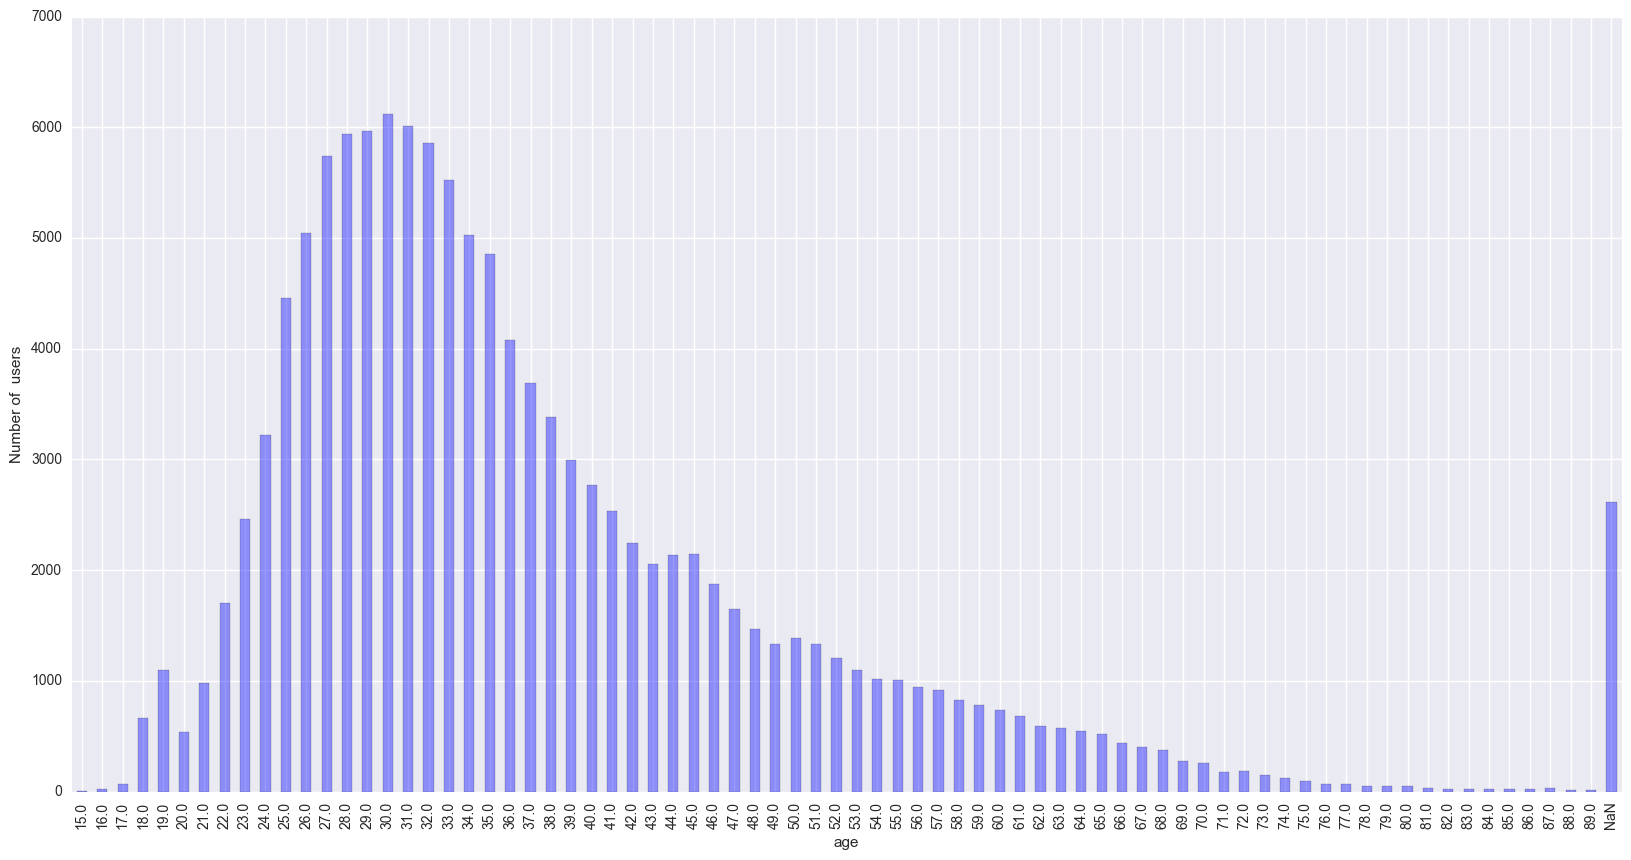

In [15]:
df_age.id.groupby(df_age.age).count().plot(kind='bar', alpha=0.4, color='b',figsize=(20,10))
plt.ylabel('Number of  users')
plt.show()

We will store the *user_id* of the users who have an invalid age in a new csv file. These users will be deleted. Having the *user_id* in a separate file will allow us to delete the corresponding entries in the file *sessions.csv*

In [25]:
df_invalid_age = df_age.loc[(df_age['age']=='NaN'), ['id']]
pd.DataFrame(df_invalid_age, columns=list(df_invalid_age.columns)).to_csv('invalid_age_user_id.csv', index=False, encoding="utf-8") 

# 3. Cleaning the date_first_booking column

In [26]:
NonBookersPercentage = df['date_first_booking'].isnull().sum()/len(df)
print('Percentage of non bookers',NonBookersPercentage*100,'%')

Percentage of non bookers 58.3473490403 %


More than half of the dataset holds non booker users

In [213]:
df_booking = copy.deepcopy(df)
df_booking = df_booking.dropna(how='any',subset=['date_first_booking']) 

In [214]:
NonBookersPercentage = df_booking['date_first_booking'].isnull().sum()/len(df)
print('Percentage of non bookers',NonBookersPercentage*100,'%')

Percentage of non bookers 0.0 %


In [215]:
def convert_time(row):
    return datetime.strptime(row['date_first_booking'], '%Y-%m-%d')

df_booking['date_first_booking'] = df_booking.apply(convert_time, axis=1)

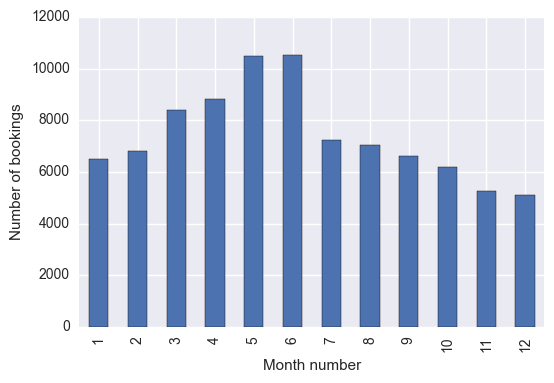

In [127]:
df_booking.id.groupby([df_booking.date_first_booking.dt.month]).count().plot(kind="bar")
plt.xlabel('Month number')
plt.ylabel('Number of bookings')

It is possible to understand from this histogram that the bookings are pretty well spread over the year. Much less bookings are made during november and december and the months of May and June are the ones where users book the most.

# 4. Cleaning the gender feature

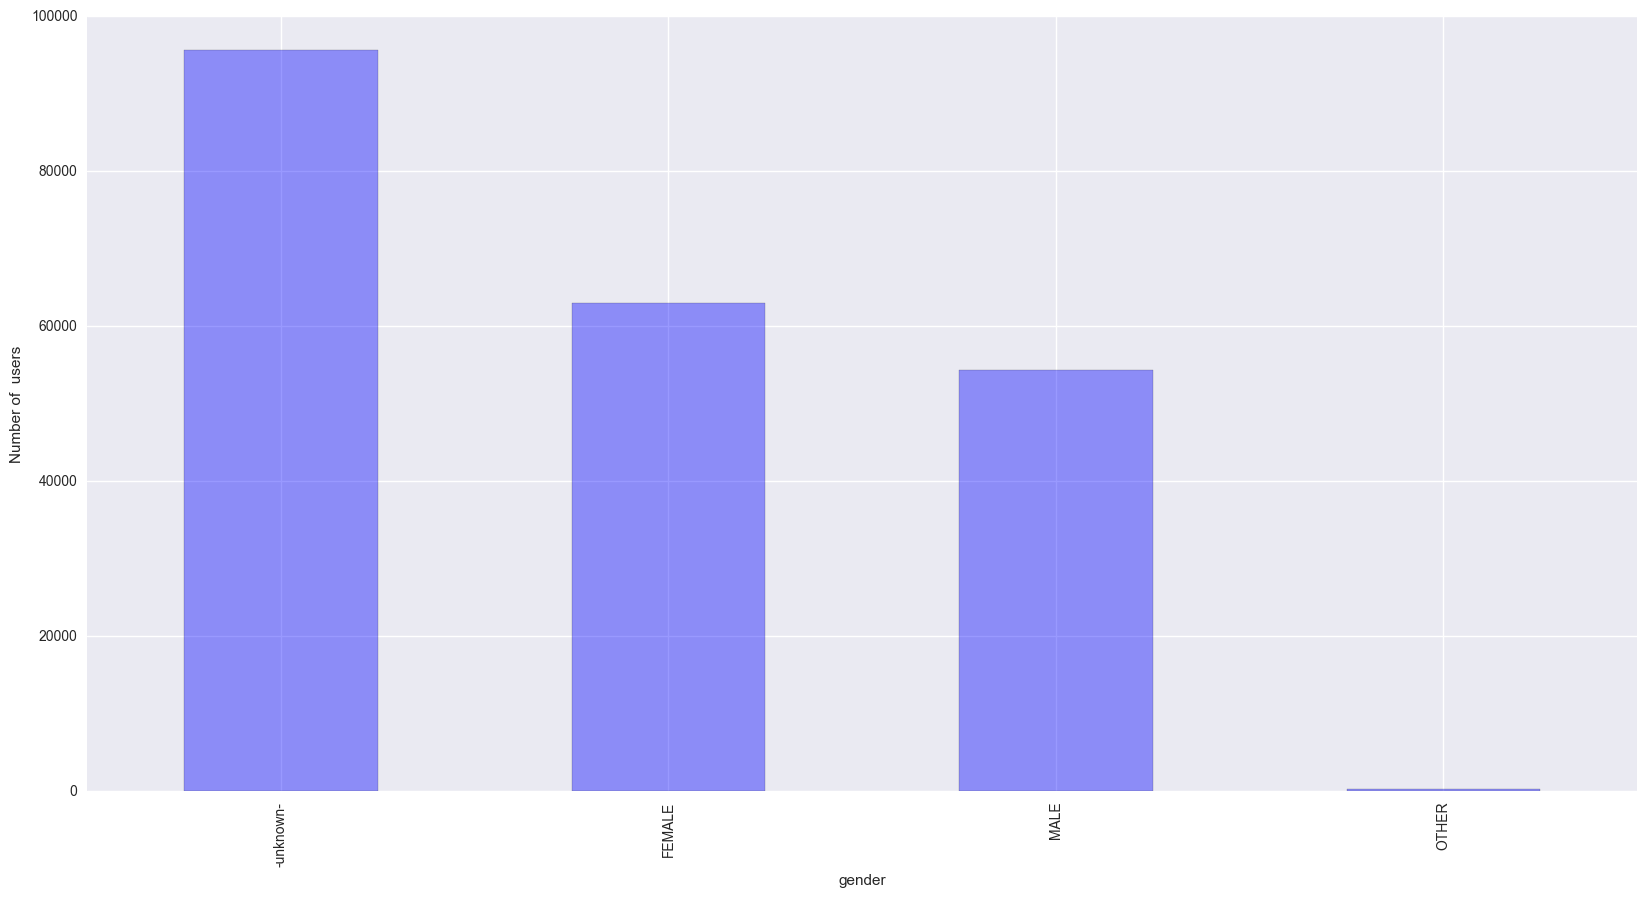

In [130]:
df.id.groupby(df.gender).count().plot(kind='bar', alpha=0.4, color='b',figsize=(20,10))
plt.ylabel('Number of  users')
plt.show()

In [149]:
print(df.gender.value_counts())

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64


In [150]:
df.loc[df['gender']=='-unknown-', 'gender'] = 'UNK'
df.loc[df['gender']=='OTHER', 'gender'] = 'UNK'
print(df.gender.value_counts())

UNK       95970
FEMALE    63041
MALE      54440
Name: gender, dtype: int64


In [156]:
df_gender = copy.deepcopy(df)
df_gender.gender = df_gender.gender.astype('category')

df_gender = df_gender[df_gender['gender'] != 'UNK']
df_gender['gender'] = df_gender['gender'].cat.remove_unused_categories()
print('\nWe are left with {} users\n'.format(df_gender.gender.shape))
print(df_gender['gender'].unique())


We are left with (117481,) users

[MALE, FEMALE]
Categories (2, object): [MALE, FEMALE]


# 5. Cleaning the first_affiliate_tracked feature

This columns represents "whats the first marketing the user interacted with before the signing up" (quoting Kaggle description)

In [158]:
print(df.first_affiliate_tracked.value_counts())

untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64


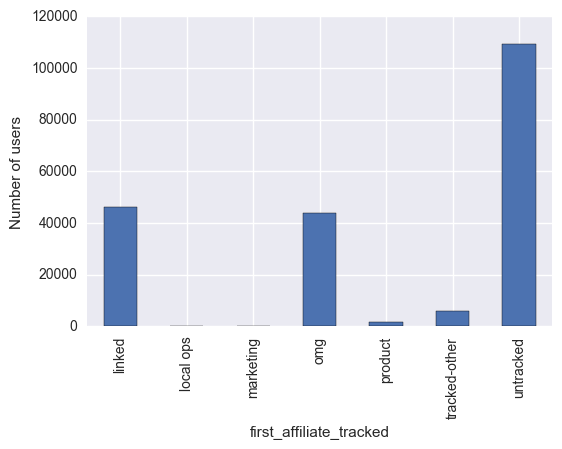

In [159]:
df.id.groupby(df.first_affiliate_tracked).count().plot(kind="bar")
plt.ylabel('Number of users')

In [160]:
NaN_fat = df['first_affiliate_tracked'].isnull().sum()/len(df)*100
print('Percentage of NaN for first_affiliate_tracked',NaN_fat,'%')

Percentage of NaN for first_affiliate_tracked 2.84140153946 %


# 6. Is the language feature relevant ?

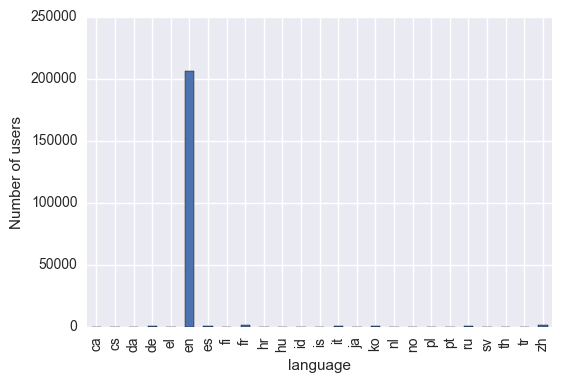

In [162]:
df.id.groupby(df.language).count().plot(kind="bar")
plt.ylabel('Number of users')

In [164]:
print(df.language.value_counts())

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
el        24
th        24
id        22
hu        18
fi        14
is         5
ca         5
hr         2
Name: language, dtype: int64


The Language feature is not relevant because the data is spread, however it is very concentrated on the english language. Hence, this feature might bring errors because classes are not balanced.

# 7. Studying the date_account_created feature

In [221]:
def convert_time2(row):
    return datetime.strptime(row['date_account_created'], '%Y-%m-%d')

df['date_account_created'] = df.apply(convert_time2, axis=1)

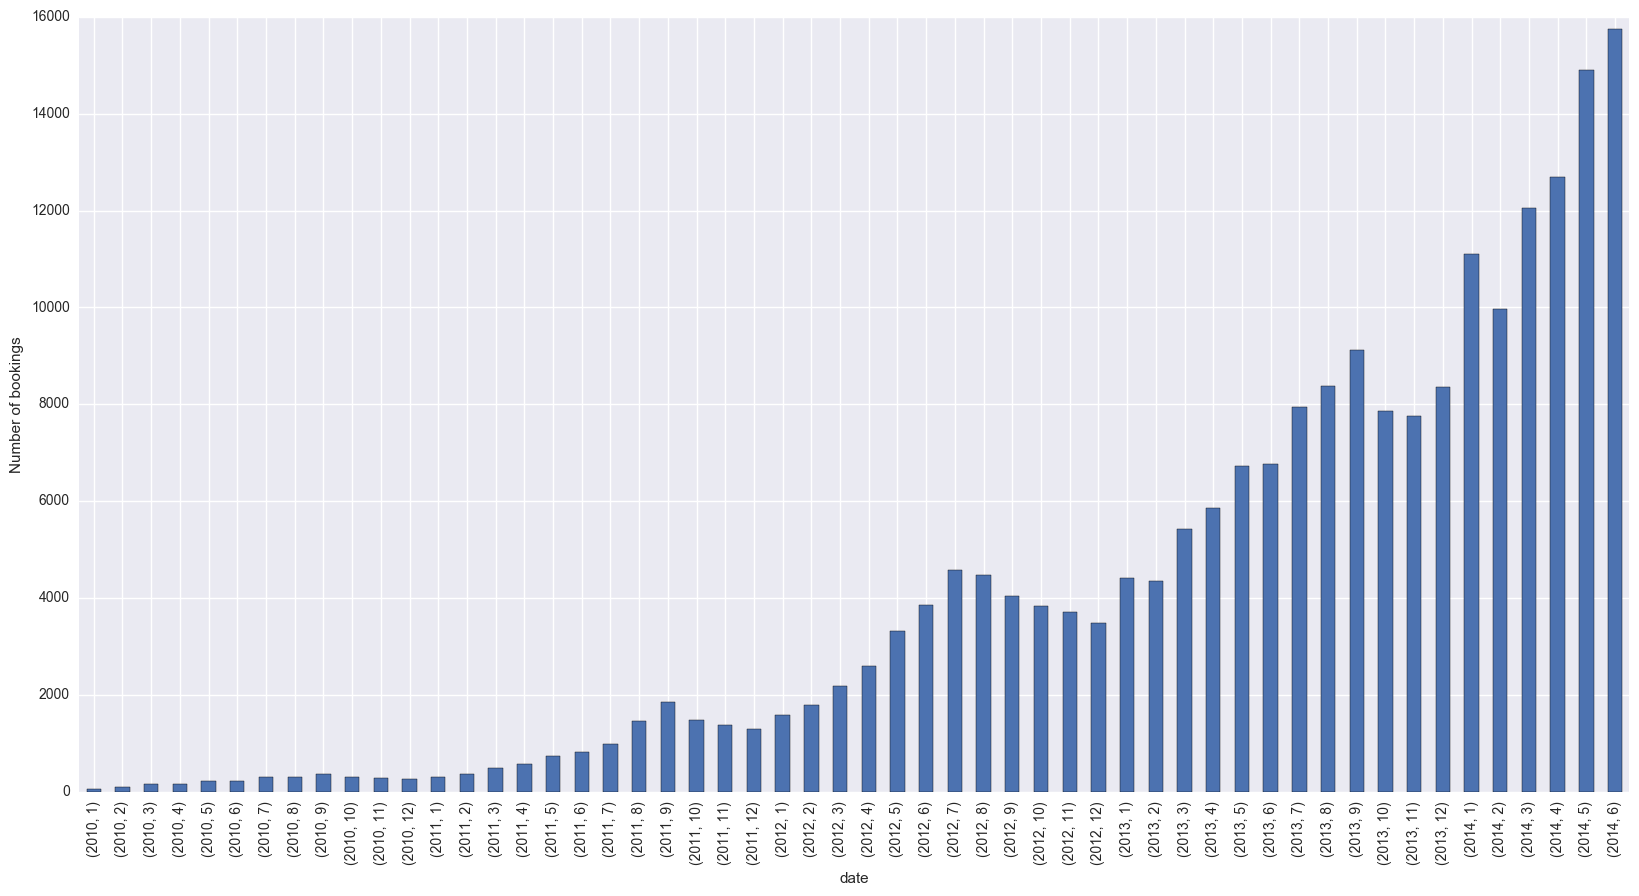

In [168]:
df.id.groupby([df.date_account_created.dt.year, df.date_account_created.dt.month]).count().plot(kind="bar",figsize=(20,10))
plt.xlabel('date')
plt.ylabel('Number of bookings')

## Correlation between the date where the account was created and the first booking

In [222]:
df_timecorr = copy.deepcopy(df)
df_timecorr = df_timecorr.dropna(how='any',subset=['date_first_booking']) 

In [223]:
df_timecorr['date_first_booking'] = df_timecorr.apply(convert_time, axis=1)

In [227]:
timediff = pd.DataFrame({'timediff': []})
#for i in df_timecorr.index:
 #   timediff[i,'timediff'] = df_timecorr['date_first_booking'][i]-df_timecorr['date_account_created'][i]
#print(timediff)

In [229]:
timediff['timediff'] = np.round((df_timecorr['date_first_booking'] - df_timecorr['date_account_created']).dt.days).astype(np.int16)

#df.id.groupby(df_timecorr.date_first_booking - df_timecorr.date_account_created).count().plot(kind="bar",figsize=(20,10))
#plt.xlabel('date')
print(timediff)

        timediff
2            -57
3            278
4           -208
5              1
6              3
7             10
8            206
9              0
10             2
12            13
15             1
17             2
19             0
20             8
21             1
22             0
25             3
27            10
28             0
29             6
30            10
36             0
41             2
44             2
45             4
46            32
47             0
49             1
51             1
52             1
...          ...
213358         4
213360       242
213369         0
213370         1
213371         2
213372       287
213373         1
213376         0
213378         4
213384       190
213385       145
213388       244
213390         8
213398         1
213400        35
213401        15
213402       288
213404         1
213405       199
213406         1
213407         0
213408         8
213409        12
213410       211
213412       207
213415         0
213439       2

# Testing cells below

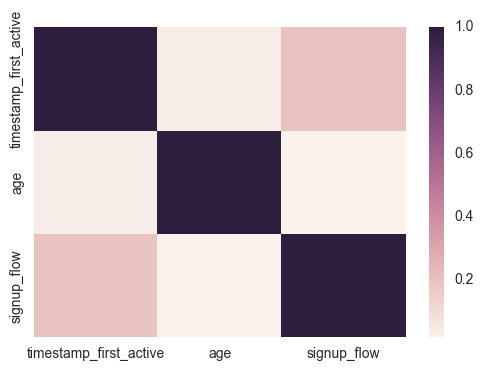

In [169]:
corr = np.abs(df.corr())
hm = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)